In [1]:
import sys
sys.path.append("../")

import os

import numpy as np
import random
import tensorflow as tf
import numpy as np

from models import DenseReparam, DenseWN
from utils import plot_loss

import matplotlib.pyplot as plt

GLOBAL_SEED = 0
DATASPLIT_SEED = 0

os.environ['PYTHONHASHSEED']=str(GLOBAL_SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
dtype = 'float64'
tf.keras.backend.set_floatx(dtype)

In [2]:
def levy_normalized(params):
    w = 1.0 + (params - 1.0) / 4.0
    res = np.sin(np.pi * w[:,0])**2 + np.sum(((w [:,0:-1] -1)**2) * (1.0+10.0*np.sin(np.pi * w[:,0:-1] + 1)**2), axis=-1) + ((w [:,-1] - 1.0)**2) * (1.0 + np.sin(2.0*np.pi*w[:,-1])**2)
    return np.array(res, dtype=dtype)

num_data_points = 50

test_features = np.arange(-10.0, 10.1, 0.1).reshape(-1, 1)
test_labels = levy_normalized(test_features).reshape(-1,1)

train_features = np.random.uniform(low=-10.0, high=10.0, size=[num_data_points,1])
epsilon = np.random.normal(loc=0.0, scale=0.1, size=[num_data_points,1])
train_labels = levy_normalized(train_features).reshape(-1,1) + epsilon

In [3]:
units = 100
n_epochs = 10000

lr_gmp = 0.1
lr_others = 0.01

os.makedirs("./figs", exist_ok=True)

# Geometric Parameterization

In [4]:
def build_reparam_dnn_model(lr):
    model = tf.keras.Sequential([
        DenseReparam(units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [5]:
reparam_dnn_model = build_reparam_dnn_model(lr=lr_gmp)
test_pred_reparam_dnn_empty = reparam_dnn_model(test_features, training=False)

In [6]:
reparam_locs = [np.zeros(units)]
reg_weights = [reparam_dnn_model.get_weights()[1].squeeze()]
print_reparam_locs = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: reparam_locs.append(
    -1.0 * reparam_dnn_model.get_weights()[0][1,:] / (reparam_dnn_model.get_weights()[0][0,:] / np.abs(reparam_dnn_model.get_weights()[0][0,:]))
))
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=500, verbose=0, mode='min')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, verbose=0, mode='min', restore_best_weights=True)

In [7]:
history_reparam_dnn = reparam_dnn_model.fit(
    train_features,
    train_labels,
    batch_size=num_data_points,
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_reparam_locs, lr_decay, early_stop]
)

In [8]:
test_pred_reparam_dnn = reparam_dnn_model(test_features, training=False)
test_results_reparam_dnn = reparam_dnn_model.evaluate(test_features, test_labels, verbose=0)
reparam_locs_np = np.stack(reparam_locs)

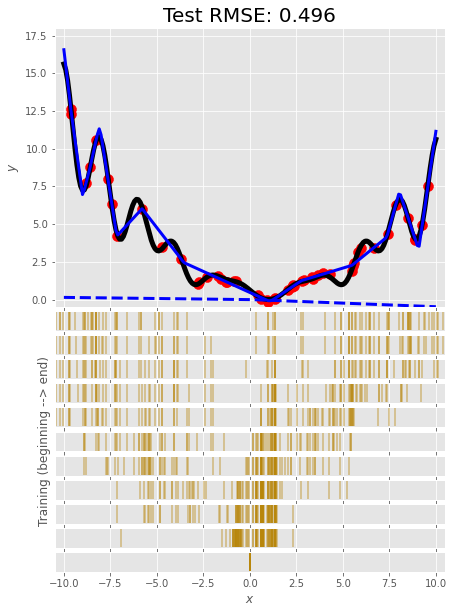

In [9]:
plt.style.use('ggplot')
n_subplots = 11
plot_every = 500
f, axes = plt.subplots(1+n_subplots, 1, gridspec_kw={'height_ratios': [7, *([0.5]*n_subplots)]} ,figsize=(7, 10))

axes[0].scatter(train_features, train_labels, color='r', s=100, label="Training data")
axes[0].plot(test_features, test_labels, c='black', label='Ground-truth', linewidth=5)
axes[0].plot(test_features, test_pred_reparam_dnn_empty, c='blue', label='Prediction before training', linewidth=3, linestyle="--")
axes[0].plot(test_features, test_pred_reparam_dnn, c='blue', label='Prediction after training', linewidth=3)
axes[0].set_xticklabels([])
axes[0].set_ylabel("$y$", fontsize=12)
axes[0].set_xlim(-10.5, 10.5)
axes[0].set_ylim(-0.5, 18)
axes[0].set_title("Test RMSE: {0:.3f}".format(np.sqrt(test_results_reparam_dnn[1])), fontsize=20)


for i in range(n_subplots):
    axes[n_subplots-i].vlines(reparam_locs_np[i*plot_every:i*plot_every+1, :], 0, 1, color='darkgoldenrod', alpha=0.5, linestyles="solid")
    axes[n_subplots-i].set_yticks([])
    axes[n_subplots-i].set_xlim(-10.5, 10.5)
    axes[i].set_xticklabels([])
    if i == n_subplots // 2 + 1:
        axes[i].set_ylabel("Training (beginning --> end)")
axes[-1].set_xlabel("$x$")


plt.subplots_adjust(hspace=0.1)
plt.savefig("./figs/levy_gmp.pdf", format="pdf", bbox_inches="tight")

# Standard Parameterization

In [11]:
def build_dnn_model(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [12]:
dnn_model = build_dnn_model(lr=lr_others)
test_pred_dnn_empty = dnn_model(test_features, training=False)

In [13]:
dnn_locs = [np.zeros(units)]
print_dnn_weights = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: dnn_locs.append(-1.0 * dnn_model.get_weights()[1] / dnn_model.get_weights()[0].squeeze()))
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=500, verbose=0, mode='min')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, verbose=0, mode='min', restore_best_weights=True)

In [14]:
history_dnn = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=num_data_points,
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_dnn_weights, lr_decay, early_stop]
)

In [15]:
dnn_locs_np = np.stack(dnn_locs)
test_pred_dnn = dnn_model(test_features, training=False)
test_results_dnn = dnn_model.evaluate(test_features, test_labels, verbose=0)

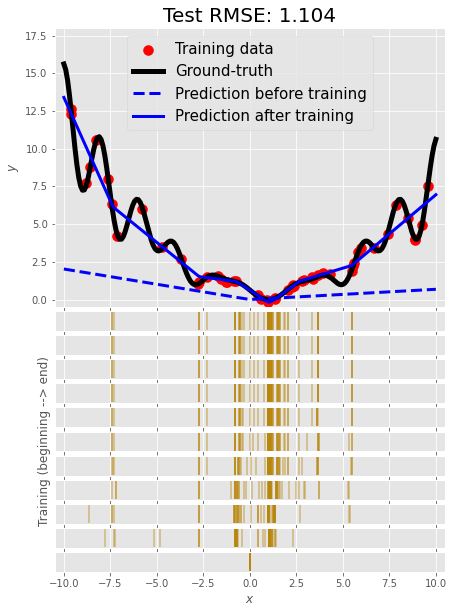

In [16]:
plt.style.use('ggplot')
n_subplots = 11
plot_every = dnn_locs_np.shape[0] // 11
f, axes = plt.subplots(1+n_subplots, 1, gridspec_kw={'height_ratios': [7, *([0.5]*n_subplots)]} ,figsize=(7, 10))

axes[0].scatter(train_features, train_labels, color='r', s=100, label="Training data")
axes[0].plot(test_features, test_labels, c='black', label='Ground-truth', linewidth=5)
axes[0].plot(test_features, test_pred_dnn_empty, c='blue', label='Prediction before training', linewidth=3, linestyle="--")
axes[0].plot(test_features, test_pred_dnn, c='blue', label='Prediction after training', linewidth=3)
axes[0].set_xticklabels([])
axes[0].set_ylabel("$y$", fontsize=12)
axes[0].set_xlim(-10.5, 10.5)
axes[0].set_ylim(-0.5, 18)
axes[0].set_title("Test RMSE: {0:.3f}".format(np.sqrt(test_results_dnn[1])), fontsize=20)
axes[0].legend(fontsize=15, loc="upper center")


for i in range(n_subplots):
    axes[n_subplots-i].vlines(dnn_locs_np[i*plot_every:i*plot_every+1, :], 0, 1, color='darkgoldenrod', alpha=0.5, linestyles="solid")
    axes[n_subplots-i].set_yticks([])
    axes[n_subplots-i].set_xlim(-10.5, 10.5)
    axes[i].set_xticklabels([])
    if i == n_subplots // 2 + 1:
        axes[i].set_ylabel("Training (beginning --> end)")
axes[-1].set_xlabel("$x$")


plt.subplots_adjust(hspace=0.1)
plt.savefig("./figs/levy_sp.pdf", format="pdf", bbox_inches="tight")

# Batch Normalization

In [18]:
def build_bn_dnn_model(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [19]:
bn_dnn_model = build_bn_dnn_model(lr=lr_others)
test_pred_bn_dnn_empty = bn_dnn_model(test_features, training=False)

In [20]:
weights = bn_dnn_model.get_weights()
bn_layer = bn_dnn_model.get_layer("batch_normalization")
mu = bn_layer.moving_mean.numpy()
sigma = np.sqrt(bn_layer.moving_variance.numpy() + bn_layer.epsilon)
gamma = bn_layer.gamma.numpy()
beta = bn_layer.beta.numpy()

w = weights[0].squeeze()
b = weights[1] + sigma * beta / gamma - mu
bn_dnn_locs = [-1.0 * b / w]

def get_feature_locs(epoch, logs):
    weights = bn_dnn_model.get_weights()
    bn_layer = bn_dnn_model.get_layer("batch_normalization")
    mu = bn_layer.moving_mean.numpy()
    sigma = np.sqrt(bn_layer.moving_variance.numpy() + bn_layer.epsilon)
    gamma = bn_layer.gamma.numpy()
    beta = bn_layer.beta.numpy()
    
    w = weights[0].squeeze()
    b = weights[1] + sigma * beta / gamma - mu
    bn_dnn_locs.append(-1.0 * b / w)

print_bn_dnn_weights = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=500, verbose=0, mode='min')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, verbose=0, mode='min', restore_best_weights=True)

In [21]:
history_bn_dnn = bn_dnn_model.fit(
    train_features,
    train_labels,
    batch_size=num_data_points,
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_bn_dnn_weights, lr_decay, early_stop]
)

In [22]:
test_pred_bn_dnn = bn_dnn_model(test_features, training=False)
test_results_bn_dnn = bn_dnn_model.evaluate(test_features, test_labels, verbose=0)
bn_dnn_locs_np = np.stack(bn_dnn_locs)

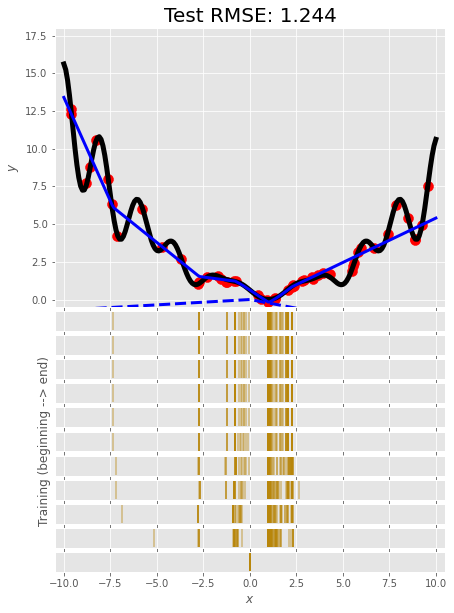

In [23]:
plt.style.use('ggplot')
n_subplots = 11
plot_every = bn_dnn_locs_np.shape[0] // 11
f, axes = plt.subplots(1+n_subplots, 1, gridspec_kw={'height_ratios': [7, *([0.5]*n_subplots)]} ,figsize=(7, 10))

axes[0].scatter(train_features, train_labels, color='r', s=100, label="Training data")
axes[0].plot(test_features, test_labels, c='black', label='Ground-truth', linewidth=5)
axes[0].plot(test_features, test_pred_bn_dnn_empty, c='blue', label='Prediction before training', linewidth=3, linestyle="--")
axes[0].plot(test_features, test_pred_bn_dnn, c='blue', label='Prediction after training', linewidth=3)
axes[0].set_xticklabels([])
axes[0].set_ylabel("$y$", fontsize=12)
axes[0].set_xlim(-10.5, 10.5)
axes[0].set_ylim(-0.5, 18)
axes[0].set_title("Test RMSE: {0:.3f}".format(np.sqrt(test_results_bn_dnn[1])), fontsize=20)


for i in range(n_subplots):
    axes[n_subplots-i].vlines(bn_dnn_locs_np[i*plot_every:i*plot_every+1, :], 0, 1, color='darkgoldenrod', alpha=0.5, linestyles="solid")
    axes[n_subplots-i].set_yticks([])
    axes[n_subplots-i].set_xlim(-10.5, 10.5)
    axes[i].set_xticklabels([])
    if i == n_subplots // 2 + 1:
        axes[i].set_ylabel("Training (beginning --> end)")
axes[-1].set_xlabel("$x$")

plt.subplots_adjust(hspace=0.1)
plt.savefig("figs/levy_batchnorm.pdf", format="pdf", bbox_inches="tight")

# Weight Normalization

In [25]:
def build_wn_dnn_model(lr):
    model = tf.keras.Sequential([
        DenseWN(units, activation='relu'),
        DenseWN(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [26]:
wn_dnn_model = build_wn_dnn_model(lr=lr_others)
test_pred_wn_dnn_empty = wn_dnn_model(test_features, training=False)

In [27]:
wn_dnn_locs = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    weights = wn_dnn_model.get_weights()[0]
    
    w = weights[0] / np.abs(weights[0]) * weights[2]
    b = weights[1]
    wn_dnn_locs.append(-1.0 * b / w)

print_wn_dnn_weights = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=500, verbose=0, mode='min')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, verbose=0, mode='min', restore_best_weights=True)

In [28]:
history_wn_dnn = wn_dnn_model.fit(
    train_features,
    train_labels,
    batch_size=num_data_points,
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_wn_dnn_weights, lr_decay, early_stop]
)

In [29]:
test_pred_wn_dnn = wn_dnn_model(test_features, training=False)
test_results_wn_dnn = wn_dnn_model.evaluate(test_features, test_labels, verbose=0)
wn_dnn_locs_np = np.stack(wn_dnn_locs)

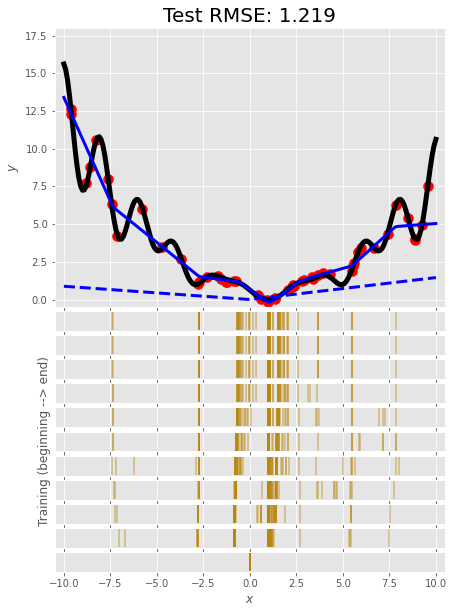

In [30]:
plt.style.use('ggplot')
n_subplots = 11
plot_every = wn_dnn_locs_np.shape[0] // 11
f, axes = plt.subplots(1+n_subplots, 1, gridspec_kw={'height_ratios': [7, *([0.5]*n_subplots)]} ,figsize=(7, 10))

axes[0].scatter(train_features, train_labels, color='r', s=100, label="Training data")
axes[0].plot(test_features, test_labels, c='black', label='Ground-truth', linewidth=5)
axes[0].plot(test_features, test_pred_wn_dnn_empty, c='blue', label='Prediction before training', linewidth=3, linestyle="--")
axes[0].plot(test_features, test_pred_wn_dnn, c='blue', label='Prediction after training', linewidth=3)
axes[0].set_xticklabels([])
axes[0].set_ylabel("$y$", fontsize=12)
axes[0].set_xlim(-10.5, 10.5)
axes[0].set_ylim(-0.5, 18)
axes[0].set_title("Test RMSE: {0:.3f}".format(np.sqrt(test_results_wn_dnn[1])), fontsize=20)

for i in range(n_subplots):
    axes[n_subplots-i].vlines(wn_dnn_locs_np[i*plot_every:i*plot_every+1, :], 0, 1, color='darkgoldenrod', alpha=0.5, linestyles="solid")
    axes[n_subplots-i].set_yticks([])
    axes[n_subplots-i].set_xlim(-10.5, 10.5)
    axes[i].set_xticklabels([])
    if i == n_subplots // 2 + 1:
        axes[i].set_ylabel("Training (beginning --> end)")
axes[-1].set_xlabel("$x$")

plt.subplots_adjust(hspace=0.1)
plt.savefig("./figs/levy_weightnorm.pdf", format="pdf", bbox_inches="tight")